# In-flight Birds detection, species detection, and counting


_________________________________________________________________________________________________________________
### Data Acquisition

In [1]:
# Import libraries
import cv2
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
import xml.etree.ElementTree as ET

### Fixing coordinates:

In [2]:
# Ortho mosaic size check
def get_image_size(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    height, width = image.shape[:2]
    return width, height

tif_file_path = "sea_birds.tif"
image_width, image_height = get_image_size(tif_file_path)

print("Image size:")
print("Width:", image_width, "pixels")
print("Height:", image_height, "pixels")


Image size:
Width: 27569 pixels
Height: 28814 pixels


In [3]:
# Convert x and y coordinates to pixel values
data = pd.read_csv('labels.csv')
data['x'] = data.X*(27569/292.48)
data['y'] = data.Y*(28814/305.69)
data = data.drop(['X','Y','unsure'],axis = 1)

### Class Distribution

Royal tern: 19742
Gray headed gull: 951
Caspian tern: 450
(unknown): 229
Great cormorant: 72
Great white Pelican: 43
Slender-billed gull: 24


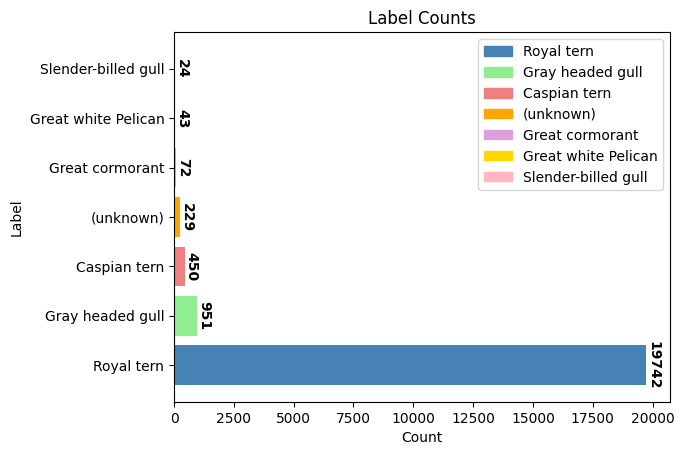

In [4]:
label_counts = data['label'].value_counts().to_dict()

# Print label counts
for label, count in label_counts.items():
    print(f'{label}: {count}')

# Plot horizontal bar graph
labels = list(label_counts.keys())
counts = list(label_counts.values())

colors = ['steelblue', 'lightgreen', 'lightcoral', 'orange', 'plum', 'gold', 'lightpink']

plt.barh(labels, counts, color=colors)
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Label Counts')

# Add count labels on each bar
for i, count in enumerate(counts):
    plt.text(count, i, str(count), ha='left', va='center', color='black', weight='bold',  rotation=270)

# Create legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors[:len(labels)]]
plt.legend(legend_elements, labels, loc='upper right')

plt.show()


### Visualzing points on orthomosaic:

In [5]:
data['label'] = data['label'].replace(['Slender-billed gull', 'Gray headed gull'], 'Gull')
data.to_csv('labels_new.csv',index=False)

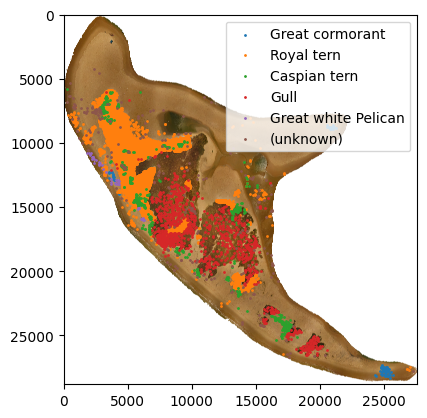

In [6]:
tif_image_path = "sea_birds.tif"
csv_file_path = "labels_new.csv"
 
image = cv2.flip(cv2.imread(tif_image_path),0)

x_coords = []
y_coords = []
labels = []
with open(csv_file_path, "r") as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if it exists

    for row in reader:
        x_coords.append(float(row[2]))
        y_coords.append(float(row[3]))
        labels.append(row[1])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

unique_labels = list(set(labels))  # Get unique labels

for label in unique_labels:
    label_x = [x for x, l in zip(x_coords, labels) if l == label]
    label_y = [y for y, l in zip(y_coords, labels) if l == label]
    plt.scatter(label_x, label_y, marker='o', label=label, s=1)

plt.legend()
# Save the figure with plotted points as a new TIF file
plt.savefig('output.tif', dpi='figure', format='tif')

plt.show()

### Creating non-overalping tiles:

In [7]:
# Open the TIFF file
image_bgr = cv2.flip(cv2.imread("sea_birds.tif"),0)
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Set the tile size (width, height)
tile_size = (800, 600)  # Adjust the values accordingly

# Get the dimensions of the image
image_width, image_height =  (27569, 28814)

# Calculate the number of tiles horizontally and vertically
num_tiles_horizontal = image_width // tile_size[0]
num_tiles_vertical = image_height // tile_size[1]

# Divide the image into tiles
tiles = []
for y in range(num_tiles_vertical):
    for x in range(num_tiles_horizontal):
        left = x * tile_size[0]
        upper = y * tile_size[1]
        right = left + tile_size[0]
        lower = upper + tile_size[1]
        tile = image[upper:lower, left:right]
        tiles.append(tile)
        tile_objects = data[
        ((data["x"] >= int(left)) & (data["x"] < int(right))) &
        ((data["y"] >= int(upper)) & (data["y"] < int(lower)))
        ]
        tile_objects['x']=tile_objects['x']-left
        tile_objects['y']=tile_objects['y']-upper
        tile_objects.to_csv(f"dataset/tile_{x}_{y}.csv", index=False)

        # you can also save the tile image
        plt.imshow(tile)
        plt.axis("off")  # Optional: Remove axis
        plt.savefig(f"dataset/tile_{x}_{y}.jpg", bbox_inches="tight", pad_inches=0)
        plt.close()


<ipython-input-7-f99bdc9c23ee>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tile_objects['x']=tile_objects['x']-left
<ipython-input-7-f99bdc9c23ee>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tile_objects['y']=tile_objects['y']-upper


In [8]:
# Resize the tiles to make sure everything worked fine
def resize_png_files(library_path, target_size=(800, 600)):
    # Loop through all files in the library path
    for filename in os.listdir(library_path):
        file_path = os.path.join(library_path, filename)

        # Check if the file is a PNG
        if os.path.isfile(file_path) and filename.lower().endswith('.jpg'):
            # Read the image
            image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

            # Resize the image
            resized_image = cv2.resize(image, target_size)

            # Write the resized image to the same file path
            cv2.imwrite(file_path, resized_image)

            print(f"Resized {filename} and saved at {file_path}")

# Example usage
library_path = 'dataset'
resize_png_files(library_path)


Resized tile_28_13.jpg and saved at dataset/tile_28_13.jpg
Resized tile_24_6.jpg and saved at dataset/tile_24_6.jpg
Resized tile_22_31.jpg and saved at dataset/tile_22_31.jpg
Resized tile_4_36.jpg and saved at dataset/tile_4_36.jpg
Resized tile_33_3.jpg and saved at dataset/tile_33_3.jpg
Resized tile_27_36.jpg and saved at dataset/tile_27_36.jpg
Resized tile_30_27.jpg and saved at dataset/tile_30_27.jpg
Resized tile_11_1.jpg and saved at dataset/tile_11_1.jpg
Resized tile_12_41.jpg and saved at dataset/tile_12_41.jpg
Resized tile_20_17.jpg and saved at dataset/tile_20_17.jpg
Resized tile_6_45.jpg and saved at dataset/tile_6_45.jpg
Resized tile_21_30.jpg and saved at dataset/tile_21_30.jpg
Resized tile_23_25.jpg and saved at dataset/tile_23_25.jpg
Resized tile_20_4.jpg and saved at dataset/tile_20_4.jpg
Resized tile_13_20.jpg and saved at dataset/tile_13_20.jpg
Resized tile_15_9.jpg and saved at dataset/tile_15_9.jpg
Resized tile_19_6.jpg and saved at dataset/tile_19_6.jpg
Resized tile_

Resized tile_32_39.jpg and saved at dataset/tile_32_39.jpg
Resized tile_16_47.jpg and saved at dataset/tile_16_47.jpg
Resized tile_21_21.jpg and saved at dataset/tile_21_21.jpg
Resized tile_13_0.jpg and saved at dataset/tile_13_0.jpg
Resized tile_1_24.jpg and saved at dataset/tile_1_24.jpg
Resized tile_2_5.jpg and saved at dataset/tile_2_5.jpg
Resized tile_23_44.jpg and saved at dataset/tile_23_44.jpg
Resized tile_28_45.jpg and saved at dataset/tile_28_45.jpg
Resized tile_14_34.jpg and saved at dataset/tile_14_34.jpg
Resized tile_19_15.jpg and saved at dataset/tile_19_15.jpg
Resized tile_32_4.jpg and saved at dataset/tile_32_4.jpg
Resized tile_15_21.jpg and saved at dataset/tile_15_21.jpg
Resized tile_14_47.jpg and saved at dataset/tile_14_47.jpg
Resized tile_28_24.jpg and saved at dataset/tile_28_24.jpg
Resized tile_31_27.jpg and saved at dataset/tile_31_27.jpg
Resized tile_25_33.jpg and saved at dataset/tile_25_33.jpg
Resized tile_3_14.jpg and saved at dataset/tile_3_14.jpg
Resized t

Resized tile_17_5.jpg and saved at dataset/tile_17_5.jpg
Resized tile_27_18.jpg and saved at dataset/tile_27_18.jpg
Resized tile_18_23.jpg and saved at dataset/tile_18_23.jpg
Resized tile_2_6.jpg and saved at dataset/tile_2_6.jpg
Resized tile_11_2.jpg and saved at dataset/tile_11_2.jpg
Resized tile_14_38.jpg and saved at dataset/tile_14_38.jpg
Resized tile_27_10.jpg and saved at dataset/tile_27_10.jpg
Resized tile_1_4.jpg and saved at dataset/tile_1_4.jpg
Resized tile_11_25.jpg and saved at dataset/tile_11_25.jpg
Resized tile_7_17.jpg and saved at dataset/tile_7_17.jpg
Resized tile_29_34.jpg and saved at dataset/tile_29_34.jpg
Resized tile_22_3.jpg and saved at dataset/tile_22_3.jpg
Resized tile_14_0.jpg and saved at dataset/tile_14_0.jpg
Resized tile_13_3.jpg and saved at dataset/tile_13_3.jpg
Resized tile_5_31.jpg and saved at dataset/tile_5_31.jpg
Resized tile_17_42.jpg and saved at dataset/tile_17_42.jpg
Resized tile_2_14.jpg and saved at dataset/tile_2_14.jpg
Resized tile_21_1.jpg

Resized tile_21_27.jpg and saved at dataset/tile_21_27.jpg
Resized tile_24_8.jpg and saved at dataset/tile_24_8.jpg
Resized tile_30_24.jpg and saved at dataset/tile_30_24.jpg
Resized tile_7_25.jpg and saved at dataset/tile_7_25.jpg
Resized tile_32_7.jpg and saved at dataset/tile_32_7.jpg
Resized tile_13_12.jpg and saved at dataset/tile_13_12.jpg
Resized tile_30_7.jpg and saved at dataset/tile_30_7.jpg
Resized tile_15_14.jpg and saved at dataset/tile_15_14.jpg
Resized tile_27_12.jpg and saved at dataset/tile_27_12.jpg
Resized tile_16_24.jpg and saved at dataset/tile_16_24.jpg
Resized tile_32_20.jpg and saved at dataset/tile_32_20.jpg
Resized tile_27_27.jpg and saved at dataset/tile_27_27.jpg
Resized tile_9_5.jpg and saved at dataset/tile_9_5.jpg
Resized tile_12_15.jpg and saved at dataset/tile_12_15.jpg
Resized tile_24_26.jpg and saved at dataset/tile_24_26.jpg
Resized tile_14_21.jpg and saved at dataset/tile_14_21.jpg
Resized tile_9_22.jpg and saved at dataset/tile_9_22.jpg
Resized til

Resized tile_9_15.jpg and saved at dataset/tile_9_15.jpg
Resized tile_32_28.jpg and saved at dataset/tile_32_28.jpg
Resized tile_28_25.jpg and saved at dataset/tile_28_25.jpg
Resized tile_24_13.jpg and saved at dataset/tile_24_13.jpg
Resized tile_27_28.jpg and saved at dataset/tile_27_28.jpg
Resized tile_7_33.jpg and saved at dataset/tile_7_33.jpg
Resized tile_32_45.jpg and saved at dataset/tile_32_45.jpg
Resized tile_13_14.jpg and saved at dataset/tile_13_14.jpg
Resized tile_0_2.jpg and saved at dataset/tile_0_2.jpg
Resized tile_27_17.jpg and saved at dataset/tile_27_17.jpg
Resized tile_14_15.jpg and saved at dataset/tile_14_15.jpg
Resized tile_9_3.jpg and saved at dataset/tile_9_3.jpg
Resized tile_7_13.jpg and saved at dataset/tile_7_13.jpg
Resized tile_1_42.jpg and saved at dataset/tile_1_42.jpg
Resized tile_13_10.jpg and saved at dataset/tile_13_10.jpg
Resized tile_0_46.jpg and saved at dataset/tile_0_46.jpg
Resized tile_10_39.jpg and saved at dataset/tile_10_39.jpg
Resized tile_31

Resized tile_21_35.jpg and saved at dataset/tile_21_35.jpg
Resized tile_0_28.jpg and saved at dataset/tile_0_28.jpg
Resized tile_32_18.jpg and saved at dataset/tile_32_18.jpg
Resized tile_14_1.jpg and saved at dataset/tile_14_1.jpg
Resized tile_29_38.jpg and saved at dataset/tile_29_38.jpg
Resized tile_1_47.jpg and saved at dataset/tile_1_47.jpg
Resized tile_19_45.jpg and saved at dataset/tile_19_45.jpg
Resized tile_13_44.jpg and saved at dataset/tile_13_44.jpg
Resized tile_8_40.jpg and saved at dataset/tile_8_40.jpg
Resized tile_28_10.jpg and saved at dataset/tile_28_10.jpg
Resized tile_21_13.jpg and saved at dataset/tile_21_13.jpg
Resized tile_3_46.jpg and saved at dataset/tile_3_46.jpg
Resized tile_32_17.jpg and saved at dataset/tile_32_17.jpg
Resized tile_14_7.jpg and saved at dataset/tile_14_7.jpg
Resized tile_30_23.jpg and saved at dataset/tile_30_23.jpg
Resized tile_20_14.jpg and saved at dataset/tile_20_14.jpg
Resized tile_19_47.jpg and saved at dataset/tile_19_47.jpg
Resized t

Resized tile_14_13.jpg and saved at dataset/tile_14_13.jpg
Resized tile_17_7.jpg and saved at dataset/tile_17_7.jpg
Resized tile_11_45.jpg and saved at dataset/tile_11_45.jpg
Resized tile_5_44.jpg and saved at dataset/tile_5_44.jpg
Resized tile_2_4.jpg and saved at dataset/tile_2_4.jpg
Resized tile_32_23.jpg and saved at dataset/tile_32_23.jpg
Resized tile_20_27.jpg and saved at dataset/tile_20_27.jpg
Resized tile_11_3.jpg and saved at dataset/tile_11_3.jpg
Resized tile_31_21.jpg and saved at dataset/tile_31_21.jpg
Resized tile_24_5.jpg and saved at dataset/tile_24_5.jpg
Resized tile_32_2.jpg and saved at dataset/tile_32_2.jpg
Resized tile_26_46.jpg and saved at dataset/tile_26_46.jpg
Resized tile_33_43.jpg and saved at dataset/tile_33_43.jpg
Resized tile_9_23.jpg and saved at dataset/tile_9_23.jpg
Resized tile_21_18.jpg and saved at dataset/tile_21_18.jpg
Resized tile_28_33.jpg and saved at dataset/tile_28_33.jpg
Resized tile_16_31.jpg and saved at dataset/tile_16_31.jpg
Resized tile_

Resized tile_16_30.jpg and saved at dataset/tile_16_30.jpg
Resized tile_10_46.jpg and saved at dataset/tile_10_46.jpg
Resized tile_29_14.jpg and saved at dataset/tile_29_14.jpg
Resized tile_2_9.jpg and saved at dataset/tile_2_9.jpg
Resized tile_9_45.jpg and saved at dataset/tile_9_45.jpg
Resized tile_28_7.jpg and saved at dataset/tile_28_7.jpg
Resized tile_8_47.jpg and saved at dataset/tile_8_47.jpg
Resized tile_15_41.jpg and saved at dataset/tile_15_41.jpg
Resized tile_27_45.jpg and saved at dataset/tile_27_45.jpg
Resized tile_31_3.jpg and saved at dataset/tile_31_3.jpg
Resized tile_7_32.jpg and saved at dataset/tile_7_32.jpg
Resized tile_11_10.jpg and saved at dataset/tile_11_10.jpg
Resized tile_20_24.jpg and saved at dataset/tile_20_24.jpg
Resized tile_4_6.jpg and saved at dataset/tile_4_6.jpg
Resized tile_1_35.jpg and saved at dataset/tile_1_35.jpg
Resized tile_15_5.jpg and saved at dataset/tile_15_5.jpg
Resized tile_29_36.jpg and saved at dataset/tile_29_36.jpg
Resized tile_4_1.jp

Resized tile_22_0.jpg and saved at dataset/tile_22_0.jpg
Resized tile_4_45.jpg and saved at dataset/tile_4_45.jpg
Resized tile_12_43.jpg and saved at dataset/tile_12_43.jpg
Resized tile_33_16.jpg and saved at dataset/tile_33_16.jpg
Resized tile_7_9.jpg and saved at dataset/tile_7_9.jpg
Resized tile_8_36.jpg and saved at dataset/tile_8_36.jpg
Resized tile_6_46.jpg and saved at dataset/tile_6_46.jpg
Resized tile_27_39.jpg and saved at dataset/tile_27_39.jpg
Resized tile_28_6.jpg and saved at dataset/tile_28_6.jpg
Resized tile_23_15.jpg and saved at dataset/tile_23_15.jpg
Resized tile_23_33.jpg and saved at dataset/tile_23_33.jpg
Resized tile_30_25.jpg and saved at dataset/tile_30_25.jpg
Resized tile_11_35.jpg and saved at dataset/tile_11_35.jpg
Resized tile_16_26.jpg and saved at dataset/tile_16_26.jpg
Resized tile_27_21.jpg and saved at dataset/tile_27_21.jpg
Resized tile_7_36.jpg and saved at dataset/tile_7_36.jpg
Resized tile_16_12.jpg and saved at dataset/tile_16_12.jpg
Resized tile_

Resized tile_15_13.jpg and saved at dataset/tile_15_13.jpg
Resized tile_5_14.jpg and saved at dataset/tile_5_14.jpg
Resized tile_0_0.jpg and saved at dataset/tile_0_0.jpg
Resized tile_8_29.jpg and saved at dataset/tile_8_29.jpg
Resized tile_1_6.jpg and saved at dataset/tile_1_6.jpg
Resized tile_2_28.jpg and saved at dataset/tile_2_28.jpg
Resized tile_5_16.jpg and saved at dataset/tile_5_16.jpg
Resized tile_9_4.jpg and saved at dataset/tile_9_4.jpg
Resized tile_9_28.jpg and saved at dataset/tile_9_28.jpg
Resized tile_12_28.jpg and saved at dataset/tile_12_28.jpg
Resized tile_8_43.jpg and saved at dataset/tile_8_43.jpg
Resized tile_26_44.jpg and saved at dataset/tile_26_44.jpg
Resized tile_31_35.jpg and saved at dataset/tile_31_35.jpg
Resized tile_19_25.jpg and saved at dataset/tile_19_25.jpg
Resized tile_0_25.jpg and saved at dataset/tile_0_25.jpg
Resized tile_3_43.jpg and saved at dataset/tile_3_43.jpg
Resized tile_6_4.jpg and saved at dataset/tile_6_4.jpg
Resized tile_22_25.jpg and sa

### Visualize tile with bird positions

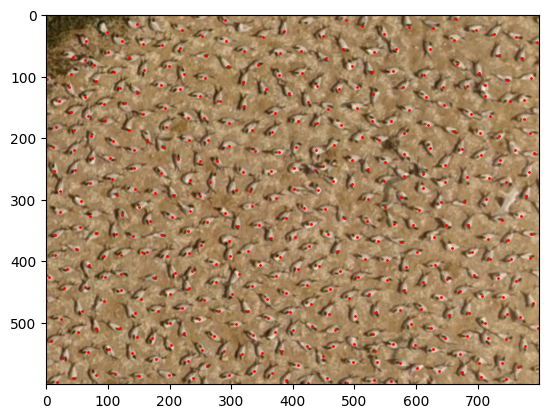

In [9]:
i,j = 7,21  # Replace with the desired tile index
tile_path = f"dataset/tile_{i}_{j}.jpg"  # Update with your tile image path
image = cv2.imread(tile_path)

# Load the object coordinates from the CSV file
csv_path = f"dataset/tile_{i}_{j}.csv"  # Update with your CSV file path
objects_df = pd.read_csv(csv_path)  # Assuming the CSV file has columns "X" and "Y" for object coordinates

x_coords = []
y_coords = []
import numpy as np

for _, row in objects_df.iterrows():
#     x_coords.append(int(np.interp(row[5], [0, 27569], [0, 800])))
#     y_coords.append(int(np.interp(row[6], [0, 28814], [0, 600])))
    x_coords.append(float(row[2]))
    y_coords.append(float(row[3]))

# with open(tile_path, "r") as file:
#     reader = csv.reader(file)
#     next(reader)  # Skip the header row if it exists

#     for row in reader:
#         x_coords.append(float(row[5]))
#         y_coords.append(float(row[6]))
#         labels.append(row[1])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.scatter(x_coords, y_coords, color='red', marker='o', s=1)

plt.show()

### Delete CSV files that have no birds:

In [10]:
def delete_csv_files_with_empty_label(directory):
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            csv_file_path = os.path.join(directory, filename)
            image_file_path = os.path.join(directory, filename.replace('.csv', '.jpg'))
            
            # Read the CSV file
            with open(csv_file_path, 'r') as csv_file:
                csv_reader = csv.DictReader(csv_file)
                
                # Check if 'label' column is empty
                if 'label' in csv_reader.fieldnames and all(row['label'] == '' for row in csv_reader):
                    # Delete the CSV file
                    os.remove(csv_file_path)
                    print(f"Deleted CSV: {filename}")
                    
                    # Delete the corresponding image file
                    if os.path.exists(image_file_path):
                        os.remove(image_file_path)
                        print(f"Deleted Image: {filename.replace('.csv', '.jpg')}")
    
    print("Deletion process completed.")

# Specify the directory containing the CSV files and images
directory_path = 'dataset'

# Call the function to delete CSV files with an empty 'label' column and their corresponding images
delete_csv_files_with_empty_label(directory_path)


Deleted CSV: tile_17_18.csv
Deleted Image: tile_17_18.jpg
Deleted CSV: tile_27_19.csv
Deleted Image: tile_27_19.jpg
Deleted CSV: tile_24_8.csv
Deleted Image: tile_24_8.jpg
Deleted CSV: tile_27_35.csv
Deleted Image: tile_27_35.jpg
Deleted CSV: tile_17_16.csv
Deleted Image: tile_17_16.jpg
Deleted CSV: tile_5_0.csv
Deleted Image: tile_5_0.jpg
Deleted CSV: tile_31_36.csv
Deleted Image: tile_31_36.jpg
Deleted CSV: tile_9_36.csv
Deleted Image: tile_9_36.jpg
Deleted CSV: tile_33_42.csv
Deleted Image: tile_33_42.jpg
Deleted CSV: tile_21_6.csv
Deleted Image: tile_21_6.jpg
Deleted CSV: tile_4_34.csv
Deleted Image: tile_4_34.jpg
Deleted CSV: tile_31_25.csv
Deleted Image: tile_31_25.jpg
Deleted CSV: tile_15_15.csv
Deleted Image: tile_15_15.jpg
Deleted CSV: tile_27_41.csv
Deleted Image: tile_27_41.jpg
Deleted CSV: tile_5_34.csv
Deleted Image: tile_5_34.jpg
Deleted CSV: tile_18_11.csv
Deleted Image: tile_18_11.jpg
Deleted CSV: tile_29_6.csv
Deleted Image: tile_29_6.jpg
Deleted CSV: tile_29_29.csv
De

Deleted CSV: tile_8_36.csv
Deleted Image: tile_8_36.jpg
Deleted CSV: tile_33_2.csv
Deleted Image: tile_33_2.jpg
Deleted CSV: tile_31_28.csv
Deleted Image: tile_31_28.jpg
Deleted CSV: tile_21_37.csv
Deleted Image: tile_21_37.jpg
Deleted CSV: tile_24_20.csv
Deleted Image: tile_24_20.jpg
Deleted CSV: tile_14_43.csv
Deleted Image: tile_14_43.jpg
Deleted CSV: tile_23_2.csv
Deleted Image: tile_23_2.jpg
Deleted CSV: tile_31_29.csv
Deleted Image: tile_31_29.jpg
Deleted CSV: tile_27_4.csv
Deleted Image: tile_27_4.jpg
Deleted CSV: tile_27_13.csv
Deleted Image: tile_27_13.jpg
Deleted CSV: tile_4_28.csv
Deleted Image: tile_4_28.jpg
Deleted CSV: tile_6_42.csv
Deleted Image: tile_6_42.jpg
Deleted CSV: tile_19_18.csv
Deleted Image: tile_19_18.jpg
Deleted CSV: tile_29_38.csv
Deleted Image: tile_29_38.jpg
Deleted CSV: tile_11_6.csv
Deleted Image: tile_11_6.jpg
Deleted CSV: tile_10_40.csv
Deleted Image: tile_10_40.jpg
Deleted CSV: tile_13_37.csv
Deleted Image: tile_13_37.jpg
Deleted CSV: tile_19_5.csv
D

### Create coco XML files

In [15]:
import os
import pandas as pd
import xml.etree.ElementTree as ET

def create_xml_coco(file_path, objects):
    root = ET.Element("annotation")

    path = ET.SubElement(root, "path")
    path.text = os.path.basename(file_path)

    source = ET.SubElement(root, "source")
    database = ET.SubElement(source, "database")
    database.text = "Unknown"
    reviewresult = ET.SubElement(source, "reviewresult")
    comment = ET.SubElement(source, "comment")
    admin = ET.SubElement(comment, "admin")
    subord = ET.SubElement(comment, "subord")

    size = ET.SubElement(root, "size")
    width_elem = ET.SubElement(size, "width")
    width_elem.text = "800"
    height_elem = ET.SubElement(size, "height")
    height_elem.text = "600"
    depth = ET.SubElement(size, "depth")
    depth.text = "3"

    segments = ET.SubElement(root, "segments")
    segments.text = "0"

    for obj in objects:
        object_elem = ET.SubElement(root, "object")
        name = ET.SubElement(object_elem, "name")
        name.text = obj["label"]

        pose = ET.SubElement(object_elem, "pose")
        pose.text = "Unspecified"

        truncated = ET.SubElement(object_elem, "truncated")
        truncated.text = "0"

        difficult = ET.SubElement(object_elem, "difficult")
        difficult.text = "0"

        bndbox = ET.SubElement(object_elem, "bndbox")
        xmin = ET.SubElement(bndbox, "xmin")
        xmin.text = str(obj["xmin"])
        xmax = ET.SubElement(bndbox, "xmax")
        xmax.text = str(obj["xmax"])
        ymin = ET.SubElement(bndbox, "ymin")
        ymin.text = str(obj["ymin"])
        ymax = ET.SubElement(bndbox, "ymax")
        ymax.text = str(obj["ymax"])

    folder = ET.SubElement(root, "folder")
    folder.text = "dataset/"

    filename = ET.SubElement(root, "filename")
    filename.text = os.path.basename(file_path)

    tree = ET.ElementTree(root)
    xml_file_path = os.path.splitext(file_path)[0] + ".xml"
    tree.write(xml_file_path)

    print(f"Generated XML file: {xml_file_path}")
    
    

# Define the dataset path where the CSV files are stored
dataset_path = "dataset"

# Label sizes dictionary
label_sizes = {
    "Great white Pelican": {"width": 80, "height": 80}, #done
    "Caspian tern": {"width": 40, "height": 40}, #done
    "Gull": {"width": 30, "height": 30}, #done
    "(unknown)": {"width": 40, "height": 40}, #done
    "Great cormorant": {"width": 60, "height": 60}, #done
    "Royal tern": {"width": 40, "height": 40} #done
}

# Iterate over each CSV file in the dataset
for file_name in os.listdir(dataset_path):
    if file_name.endswith(".csv"):
        
        file_path = os.path.join(dataset_path, file_name)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Initialize a list to store the objects
        objects = []

        # Iterate over each row
        for index, row in df.iterrows():
            label = row["label"]
            center_x = row["x"]
            center_y = row["y"]

            # Check if the label is one of the desired labels
            if label in label_sizes:
                size = label_sizes[label]
                width = size["width"]
                height = size["height"]

                # Calculate the bounding box coordinates
                xmin = max(center_x - width / 2, 0)
                ymin = max(center_y - height / 2, 0)
                xmax = min(center_x + width / 2, 800)
                ymax = min(center_y + height / 2, 600)

                # Create an object dictionary
                obj = {
                    "label": label,
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax
                }

                # Append the object to the list
                objects.append(obj)
        file_path = os.path.splitext(file_path+'.jpg'
        # Create XML in COCO format
        create_xml_coco(file_path, objects)


In [13]:
# delete all csv files
!rm dataset/*.csv

### visualizing object positions from XML files

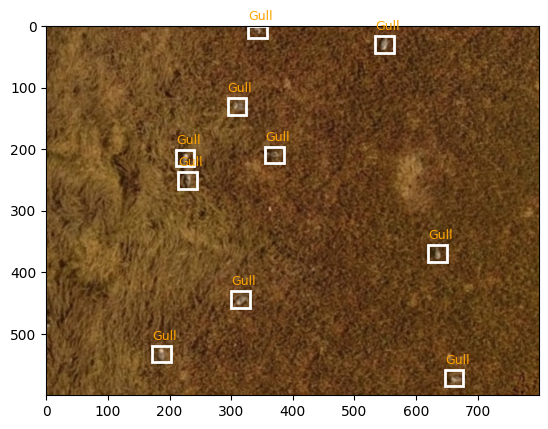

In [17]:
import matplotlib.patches as patches
# Path to the image and annotation files
i,j=9,23
image_path = f'dataset/tile_{i}_{j}.jpg'
annotation_path = f'dataset/tile_{i}_{j}.xml'

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Read the XML file
tree = ET.parse(annotation_path)
root = tree.getroot()

# Iterate through all object annotations
for obj in root.findall('object'):
    # Extract class label
    class_label = obj.find('name').text

    # Extract bounding box coordinates
    bbox = obj.find('bndbox')
    xmin = int(round(float(bbox.find('xmin').text)))
    ymin = int(round(float(bbox.find('ymin').text)))
    xmax = int(round(float(bbox.find('xmax').text)))
    ymax = int(round(float(bbox.find('ymax').text)))-3

    # Draw the bounding box on the image
    # Create a rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='w', facecolor='none')

    # Add the rectangle patch to the axes
    ax.add_patch(rect)
    ax.text(xmin, ymin - 10, class_label, fontsize=9, color='orange')

# Show the plot
plt.show()

#### Note:
____________________________________________________________________________________________________________________
We created COCO XML files because we tried using SSD and Faster RCNN with this data initially, but for YOLOv8 we had to convert the XML files to YOLO format
____________________________________________________________________________________________________________________

### Image Agumentation

In [78]:
import imgaug.augmenters as iaa
import xml.etree.ElementTree as ET
import os
import numpy as np
from PIL import Image

# Directory paths
image_dir = ''
annotation_dir = ''

# Augmentation settings
augmentations = {
#     'rotate_90': iaa.Affine(rotate=90),
#     'rotate_180': iaa.Affine(rotate=180),
#    'rotate_270': iaa.Affine(rotate=270),
#    'flip': iaa.Fliplr(1.0)
}

# Iterate through the images
for image_file in os.listdir(image_dir):
    if image_file.endswith('.jpg'):
        image_path = os.path.join(image_dir, image_file)
        image = Image.open(image_path)
        image_name = os.path.splitext(image_file)[0]

        # Convert PIL image to NumPy array
        image_array = np.array(image)

        # Iterate through the augmentations
        for aug_name, augmentation in augmentations.items():
            augmented_image_array = augmentation(image=image_array)
            augmented_image = Image.fromarray(augmented_image_array)

            augmented_image_path = os.path.join(image_dir, f'{image_name}_{aug_name}.jpg')
            augmented_image.save(augmented_image_path)

            # Update XML annotations
            annotation_file = os.path.join(annotation_dir, f'{image_name}.xml')
            augmented_annotation_file = os.path.join(annotation_dir, f'{image_name}_{aug_name}.xml')

            tree = ET.parse(annotation_file)
            root = tree.getroot()

            # Update image filename in the annotation XML
            root.find('filename').text = f'{image_name}_{aug_name}.jpg'

            # Apply necessary transformations to bounding boxes in the annotation XML
            for obj in root.findall('object'):
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                if aug_name == 'rotate_90':
                    xmin, ymin, xmax, ymax = image.width-ymin-100, xmin - 100, image.width-ymax-100, xmax-100
                elif aug_name == 'rotate_180':
                    xmin, ymin, xmax, ymax = image.width - xmax, image.height - ymax, image.width - xmin, image.height - ymin
                elif aug_name == 'rotate_270':
                    xmin, ymin, xmax, ymax = ymax+100, image.height-xmin+100 , ymin+100, image.height-xmax+100
                elif aug_name == 'flip':
                    xmin, xmax = image.width - xmax, image.width - xmin

                bbox.find('xmin').text = str(xmin)
                bbox.find('ymin').text = str(ymin)
                bbox.find('xmax').text = str(xmax)
                bbox.find('ymax').text = str(ymax)

            # Save the augmented annotation XML
            tree.write(augmented_annotation_file)

### Remove the Royal tern tag to down sample

In [72]:
import os
import xml.etree.ElementTree as ET

def remove_object_from_xml(xml_path, object_name):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Find all object elements with the specified name
    objects = root.findall("object[name='{}']".format(object_name))

    # Remove the found objects from the XML tree
    for obj in objects:
        root.remove(obj)

    # Save the modified XML back to the file
    tree.write(xml_path)

# Set the directory path containing the COCO XML files
folder_path = ''

# Iterate over all XML files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".xml"):
        xml_file_path = os.path.join(folder_path, filename)
        remove_object_from_xml(xml_file_path, 'Royal tern')

### Balanced Dataset

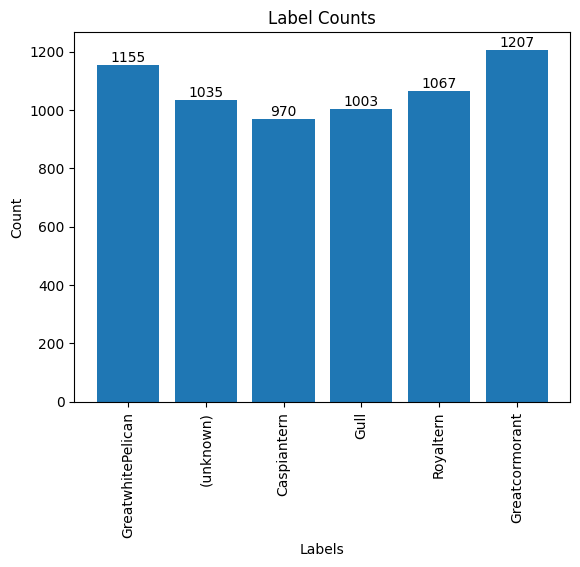

In [8]:
import os
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt

def parse_xml_file(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)
    
    return labels

def count_labels(folder_path):
    all_labels = []
    
    for file in os.listdir(folder_path):
        if file.endswith('.xml'):
            xml_file = os.path.join(folder_path, file)
            labels = parse_xml_file(xml_file)
            all_labels.extend(labels)
    
    return Counter(all_labels)

def plot_label_counts(label_counts):
    labels = label_counts.keys()
    counts = label_counts.values()
    
    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Counts')
    plt.xticks(rotation=90)

    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.show()

folder_path = 'Desktop/dataset/train'

label_counts = count_labels(folder_path)
plot_label_counts(label_counts)


In [10]:
label_counts

Counter({'GreatwhitePelican': 1155,
         '(unknown)': 1035,
         'Caspiantern': 970,
         'Gull': 1003,
         'Royaltern': 1067,
         'Greatcormorant': 1207})